<a href="https://colab.research.google.com/github/Ajay1687/Datasets/blob/master/BlueOwl_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Attuchirayil Krishnankutty**

**Date : 02/01/2020**

**Description: Processed variables by binning and encoding, then first predicted missing Gender. And then, since the data is highly imbalanced used a variant of SMOTE which involved first oversampling then undersampling data, and in the end used a Random Forest Classifier**

**AUC: 0.955**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import confusion_matrix, classification_report 

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [346]:
train.shape,test.shape

((10000, 10), (10000, 9))

In [347]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9731 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
outcome                       10000 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 781.4+ KB


**We can see the class imbalance below**

In [348]:
train['outcome'].value_counts()

0    9018
1     982
Name: outcome, dtype: int64

In [349]:
train.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


**Null values are present in the Gender column**

In [350]:
train.isnull().sum()

age                             0
cost_of_ad                      0
device_type                     0
gender                        269
in_initial_launch_location      0
income                          0
n_drivers                       0
n_vehicles                      0
prior_ins_tenure                0
outcome                         0
dtype: int64

In [351]:
train['gender'].value_counts()

F    4970
M    4761
Name: gender, dtype: int64

**Apart from the missing values, Gender is well balanced**

In [352]:
train['device_type'].value_counts()

desktop    2032
Android    2023
laptop     1991
other      1986
iPhone     1968
Name: device_type, dtype: int64

In [353]:
train['n_vehicles'].value_counts()

3    3355
1    3333
2    3312
Name: n_vehicles, dtype: int64

In [354]:
train['n_vehicles'].value_counts()

3    3355
1    3333
2    3312
Name: n_vehicles, dtype: int64

In [355]:
train['in_initial_launch_location'].value_counts()

0    5025
1    4975
Name: in_initial_launch_location, dtype: int64

**We have Gender, n_driver,n_vehicles,in_initial_launch_location as Categorical variables**

**We need to normalize income column, also perform binning for columns age, prior_ins_tenure**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


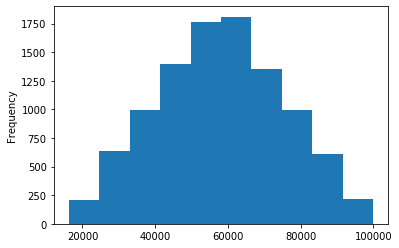

In [356]:
train['income'].plot('hist')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


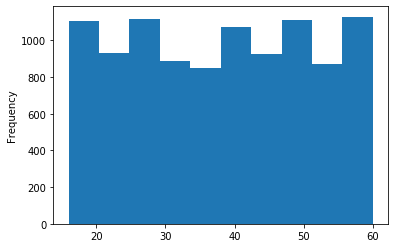

In [357]:
train['age'].plot('hist')

**Normalizig the income, performing on both train and test**

In [0]:
#Train
x = train[['income']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x)

train['normal_income'] = pd.DataFrame(x_scaled)

In [0]:
#Test
x = test[['income']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x)

test['normal_income'] = pd.DataFrame(x_scaled)

In [360]:
train.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,normal_income
0,56,0.005737,iPhone,M,0,62717,2,1,4,0,0.555169
1,50,0.004733,desktop,F,0,64328,2,3,2,0,0.574413
2,54,0.004129,laptop,M,0,83439,1,3,7,0,0.802700
3,16,0.005117,Android,F,0,30110,2,3,0,0,0.165669
4,37,0.003635,desktop,M,0,76565,2,1,5,0,0.720588


**One hot encoding device_type,n_drivers,n_vehicles**

In [0]:
new_train = pd.get_dummies(train,prefix=['drivers','device','vehicle'],columns = ['n_drivers','device_type','n_vehicles'],drop_first=True)
new_test = pd.get_dummies(test,prefix=['drivers','device','vehicle'],columns = ['n_drivers','device_type','n_vehicles'],drop_first=True)

In [0]:
new_train.drop(columns = 'income',inplace = True)
new_test.drop(columns = 'income',inplace = True)

In [363]:
new_train.head()

,age,cost_of_ad,gender,in_initial_launch_location,prior_ins_tenure,outcome,normal_income,drivers_2,device_desktop,device_iPhone,device_laptop,device_other,vehicle_2,vehicle_3
0,56,0.005737,M,0,4,0,0.555169,1,0,1,0,0,0,0
1,50,0.004733,F,0,2,0,0.574413,1,1,0,0,0,0,1
2,54,0.004129,M,0,7,0,0.802700,0,0,0,1,0,0,1
3,16,0.005117,F,0,0,0,0.165669,1,0,0,0,0,0,1
4,37,0.003635,M,0,5,0,0.720588,1,1,0,0,0,0,0


**Binning the Age age and ins_tenure columns**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


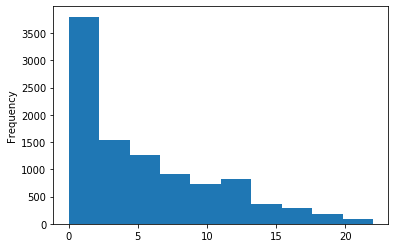

In [364]:
new_train['prior_ins_tenure'].plot('hist')

In [0]:
new_train['tenure_bin'] = pd.qcut(new_train['prior_ins_tenure'],q = 4,labels=[1,2,3,4])
new_test['tenure_bin'] = pd.qcut(new_test['prior_ins_tenure'],q = 4,labels=[1,2,3,4])
#Age Bins
age_bins = [10,25,35,50,70]
new_train['age_bin'] = pd.cut(new_train['age'],bins = age_bins,labels=['young','adult','mid','senior'])
new_test['age_bin'] = pd.cut(new_test['age'],bins = age_bins,labels=['young','adult','mid','senior'])

In [0]:
new_train.drop(columns=['age','prior_ins_tenure'],inplace=True)
new_test.drop(columns=['age','prior_ins_tenure'],inplace=True)

In [367]:
new_train.head()

,cost_of_ad,gender,in_initial_launch_location,outcome,normal_income,drivers_2,device_desktop,device_iPhone,device_laptop,device_other,vehicle_2,vehicle_3,tenure_bin,age_bin
0,0.005737,M,0,0,0.555169,1,0,1,0,0,0,0,2,senior
1,0.004733,F,0,0,0.574413,1,1,0,0,0,0,1,2,mid
2,0.004129,M,0,0,0.802700,0,0,0,1,0,0,1,3,senior
3,0.005117,F,0,0,0.165669,1,0,0,0,0,0,1,1,young
4,0.003635,M,0,0,0.720588,1,1,0,0,0,0,0,3,mid


In [0]:
#Encodig binned columns age and tenure
new_train = pd.get_dummies(new_train,prefix=['age'],columns = ['age_bin'],drop_first=True)
new_test = pd.get_dummies(new_test,prefix=['age'],columns = ['age_bin'],drop_first=True)

new_train = pd.get_dummies(new_train,prefix=['tenure'],columns = ['tenure_bin'],drop_first=True)
new_test = pd.get_dummies(new_test,prefix=['tenure'],columns = ['tenure_bin'],drop_first=True)


**We can now predict the Gender missing values first**

In [0]:
Y_outcome = new_train['outcome']

In [0]:
new_train.drop(['outcome'],axis =1,inplace=True)

In [0]:
#Train Data
gender_test = new_train[new_train['gender'].isnull()]
gender_train = new_train[new_train['gender'].notnull()]

#Test Data
new_test_gender_test = new_test[new_test['gender'].isnull()]
new_test_gender_train = new_test[new_test['gender'].notnull()]

In [372]:
gender_train.shape,gender_test.shape

((9731, 17), (269, 17))

In [0]:
gender_train = pd.get_dummies(gender_train,prefix=['Gen'],columns = ['gender'],drop_first=True)
new_test_gender_train = pd.get_dummies(new_test_gender_train,prefix=['Gen'],columns = ['gender'],drop_first=True)

In [374]:
gender_train.head()

,cost_of_ad,in_initial_launch_location,normal_income,drivers_2,device_desktop,device_iPhone,device_laptop,device_other,vehicle_2,vehicle_3,age_adult,age_mid,age_senior,tenure_2,tenure_3,tenure_4,Gen_M
0,0.005737,0,0.555169,1,0,1,0,0,0,0,0,0,1,1,0,0,1
1,0.004733,0,0.574413,1,1,0,0,0,0,1,0,1,0,1,0,0,0
2,0.004129,0,0.802700,0,0,0,1,0,0,1,0,0,1,0,1,0,1
3,0.005117,0,0.165669,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.003635,0,0.720588,1,1,0,0,0,0,0,0,1,0,0,1,0,1


In [0]:
Y_gender = gender_train['Gen_M']


In [376]:
#Train
gender_train.drop(['Gen_M'],axis =1,inplace=True)
gender_test.drop(['gender'],axis =1,inplace=True)

#Test
#new_test_gender_train.drop(['Gen_M'],axis =1,inplace=True)
new_test_gender_test.drop(['gender'],axis =1,inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
X_gender_train, X_gender_test, y_gender_train, y_gender_test = train_test_split(gender_train, Y_gender, test_size=0.33, random_state=42)

In [378]:
X_gender_train.shape,y_gender_train.shape

((6519, 16), (6519,))

In [379]:
y_gender_test.value_counts()

0    1671
1    1541
Name: Gen_M, dtype: int64

In [380]:
gender_model=RandomForestClassifier(n_estimators=100)
gender_model.fit(X_gender_train,y_gender_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
gender_prediction = gender_model.predict(X_gender_test)

In [382]:
roc_auc_score(y_gender_test, gender_prediction)

0.9848548219794012

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(y_gender_test, gender_prediction)

In [384]:
print(confusion_matrix(y_gender_test,gender_prediction))

[[1654   17]
 [  31 1510]]


**The model Prediction for gender looks good so we can go ahead and predict the missing gender using this model**

In [385]:
gender_test.head()

,cost_of_ad,in_initial_launch_location,normal_income,drivers_2,device_desktop,device_iPhone,device_laptop,device_other,vehicle_2,vehicle_3,age_adult,age_mid,age_senior,tenure_2,tenure_3,tenure_4
15,0.003519,0,0.664970,0,0,0,0,0,0,1,1,0,0,0,1,0
38,0.005529,0,0.846694,1,0,1,0,0,0,1,0,0,1,0,1,0
91,0.005510,0,0.431249,0,0,1,0,0,0,1,1,0,0,1,0,0
113,0.004282,0,0.677740,1,0,0,0,0,1,0,0,1,0,0,0,1
122,0.005518,0,0.408338,1,0,1,0,0,0,1,1,0,0,1,0,0


In [386]:
new_test_gender_test.columns

Index(['cost_of_ad', 'in_initial_launch_location', 'normal_income',
       'drivers_2', 'device_desktop', 'device_iPhone', 'device_laptop',
       'device_other', 'vehicle_2', 'vehicle_3', 'age_adult', 'age_mid',
       'age_senior', 'tenure_2', 'tenure_3', 'tenure_4'],
      dtype='object')

In [387]:
gender_test.columns

Index(['cost_of_ad', 'in_initial_launch_location', 'normal_income',
       'drivers_2', 'device_desktop', 'device_iPhone', 'device_laptop',
       'device_other', 'vehicle_2', 'vehicle_3', 'age_adult', 'age_mid',
       'age_senior', 'tenure_2', 'tenure_3', 'tenure_4'],
      dtype='object')

In [0]:
missing_prediction = gender_model.predict(gender_test)

#Predicitng for the test data
missing_test_gender_prediction = gender_model.predict(new_test_gender_test)

In [389]:
#Setting values back to train and test dat frames
gender_train['Gen_M'] = Y_gender
gender_test['Gen_M'] = missing_prediction

#Test Data
new_test_gender_test['Gen_M'] = missing_test_gender_prediction

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [390]:
gender_train.columns

Index(['cost_of_ad', 'in_initial_launch_location', 'normal_income',
       'drivers_2', 'device_desktop', 'device_iPhone', 'device_laptop',
       'device_other', 'vehicle_2', 'vehicle_3', 'age_adult', 'age_mid',
       'age_senior', 'tenure_2', 'tenure_3', 'tenure_4', 'Gen_M'],
      dtype='object')

**Concatenating the two dataframes woth gender values**

In [0]:
new_df= pd.concat([gender_test,gender_train])

#Test Data
new_test_df= pd.concat([new_test_gender_test,new_test_gender_train])

In [392]:
new_df['Gen_M'].value_counts()

1    5026
0    4974
Name: Gen_M, dtype: int64

In [393]:
new_df.shape

(10000, 17)

In [0]:
Y = Y_outcome

In [0]:
X =new_df

**Handling the Imbalanced data using SMOTE variant**

In [0]:
from imblearn.combine import SMOTETomek

In [397]:
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.33, random_state=42)

In [399]:
target_model=RandomForestClassifier(n_estimators=100)

#Traing the model
target_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
preds = target_model.predict(X_test)

In [401]:
roc_auc_score(y_test, preds)

0.9353473595300712

**AUC score is 0.935 from this model**

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)

In [0]:
roc_auc = metrics.auc(fpr, tpr)

**Plotting the ROC**

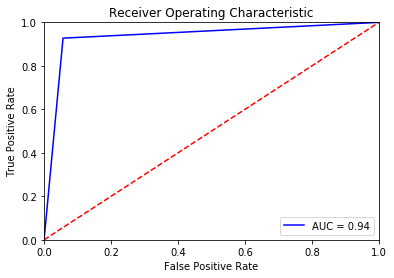

In [404]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**We can now use the test data we prepared all the way**

In [405]:
new_test_df.head()

,cost_of_ad,in_initial_launch_location,normal_income,drivers_2,device_desktop,device_iPhone,device_laptop,device_other,vehicle_2,vehicle_3,age_adult,age_mid,age_senior,tenure_2,tenure_3,tenure_4,Gen_M
69,0.003440,0,0.630430,0,1,0,0,0,1,0,1,0,0,1,0,0,1
78,0.003442,0,0.234080,1,0,0,0,1,1,0,1,0,0,0,1,0,1
81,0.003662,0,0.660314,0,1,0,0,0,0,1,0,1,0,0,1,0,1
109,0.003578,0,0.113829,1,0,0,0,0,0,1,0,0,0,1,0,0,1
222,0.003304,1,0.418298,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [0]:
test_prediction = target_model.predict(new_test_df)

In [0]:
#Addng the prediction to test data
new_test_df['predicted_outcome'] = test_prediction

**First five predicted values for test data**

In [408]:
new_test_df['predicted_outcome'].head()

69     0
78     0
81     0
109    1
222    0
Name: predicted_outcome, dtype: int64